$\def \dot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \adot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \cD {\mathcal{D}}$
$\def \bc {\mathbf{c}}$
$\def \bv {\mathbf{v}}$
$\def \bG {\mathbf{G}}$

# Greedy algorithms with a 2d manifold

Here we consider the solutions of the PDE $u_h(a(y))$ where $y\in\mathbb{R}^2$, $a(y) = y_1 \chi_{D_1}(x) + y_2 \chi_{D_2}(x)$, and $D_1 = [0,1/2) \times [0,1]$ and $D_2 = [1/2, 1] \times [0,1]$, and $\chi_{D_1}$, $\chi_{D_2}$ are the indicator functions on $D_1$, $D_2$.

We're given our measurement space $W_m = \mathrm{span}\{w_1,\ldots,w_m\}$. We have a series of measurements $\langle w_i, u\rangle_V$, and we write $w := P_{W_m} u$, the projection of $u$ in $W_m$. We try random, even, and even sinusoidal measurements.

__Remarks:__
 - __Note that $\dot{\cdot}{\cdot} = \dot{\cdot}{\cdot}_{V_h}$ here.__
 - We can __assume that the $\omega_i$ are orthonormal__ as it is a fixed basis.
 - We store $\dot{\omega_i}{v}$ for each $v\in \cD$, so can we di all projections and inner-products in $\mathbb{R}^m$? And furthermore without the need of a Gram matrix $\dot{\phi_i}{\phi_j}$ to do the projection or orthonormalisation of $\phi_i$?
 - Finally, remember that _we can not know anything about $u$ other than $w :=P_{W_m} u$_, and we abuse notation slightly and also write $w=\dot{\omega_i}{u}$ for the vector in $\mathbb{R}^m$.

We have a dictionary $\cD$ of solutions $v(y)$, which we get from generating points in $y\in\mathbb{R}^{2}$ and then $v(y) = \frac{u_h(a(y))}{\| u_h(a(y)) \|_{V_h}}$ (i.e. we normalise all elements). 

### Algorithm 1

The first algorithm doesn't depend on $W_m$ at all. Given the dictionary $\cD$ we chose
$$
\phi_1 = {\arg\max}_{v\in\cD} \| v \|
$$
and given $V_{n}=\mathrm{span}\{\phi_1, \ldots, \phi_n\}$, our next choice is
$$
\phi_{n+1} = {\arg\max}_{v\in\cD} \| v - P_{V_n} v \|
$$

### Algorithm 2

The first element $\phi_1$ is chosen as 
$$ \phi_1 = {\arg\max}_{v\in \cD} \adot{w}{v}$$
and given our collection $V_{n}=\mathrm{span}\{\phi_1, \ldots, \phi_n\}$,our next choice is
$$ \phi_{n+1} = {\arg\max}_{v\in \cD} \adot{w}{P_{V_n^\perp} v}$$

### Algorithm 3

$$ \phi_1 = {\arg\max}_{v\in \cD} \adot{w}{v}$$
and given our collection $V_{n}=\mathrm{span}\{\phi_1, \ldots, \phi_n\}$,our next choice is
$$ \phi_{n+1} = {\arg\max}_{v\in \cD} \adot{P_{W_m \cap V_n^\perp} w}{ v}$$


In [1]:
import numpy as np
import scipy as sp
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

import sys
sys.path.append("../../")
import pyApproxTools as pat
importlib.reload(pat)

%matplotlib inline

def make_2d_param_soln(points, fem_div, a_bar=1.0, c=0.5, f=1.0, verbose=False):
    
    solns = []
    fields = []

    for p in points:
        field = pat.PWConstantSqDyadicL2(a_bar + c * np.repeat(p[:,np.newaxis], 2, axis=1).T)
        fields.append(field)
        # Then the fem solver (there a faster way to do this all at once? This will be huge...
        fem_solver = pat.DyadicFEMSolver(div=fem_div, rand_field = field, f = 1)
        fem_solver.solve()
        solns.append(fem_solver.u)
        
    return solns, fields

### Generate the solution $u$ that we want to approximate

[ 0.8  0.1]


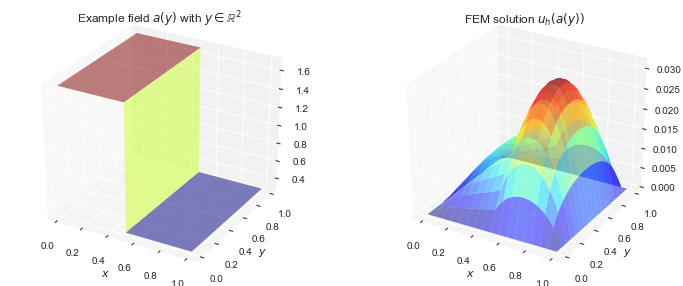

In [2]:
fem_div = 7

a_bar = 0.1
c = 2.0

np.random.seed(2)

y = np.array([[0.8, 0.1]])
print(y[0])
u, a = make_2d_param_soln(y, fem_div, a_bar=a_bar, c=c)
u = u[0]
a = a[0]

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
a.plot(ax, title='Example field $a(y)$ with $y\in\mathbb{R}^2$')
ax = fig.add_subplot(1, 2, 2, projection='3d')
u.plot(ax, title='FEM solution $u_h(a(y))$')
plt.show()

### Generate the basis $W_m$ of randomly placed local averages

m = 64


[]

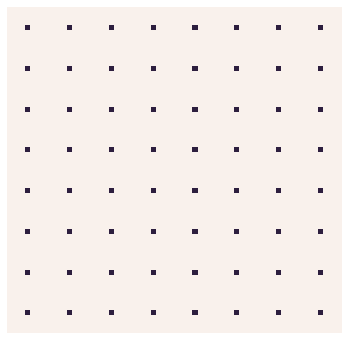

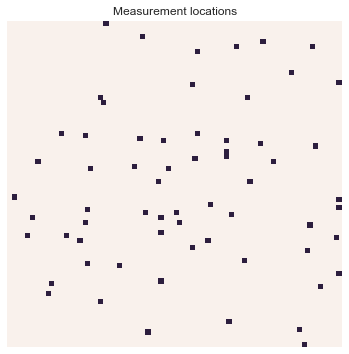

In [3]:
# local_width is the width of the measurement squares in terms of FEM mesh squares
width_div = 1
local_width = 2**width_div
spacing_div = 4

Wm_reg, Wloc_reg = pat.make_local_avg_grid_basis(width_div, spacing_div, fem_div, return_map=True)
Wm_reg = Wm_reg.orthonormalise()

m = Wm_reg.n
print('m =', m)

# We make the ambient spaces for Wm and Vn
np.random.seed(2)

Wm_rand, Wloc_rand = pat.make_pw_local_avg_random_basis(m=m, div=fem_div, width=local_width, return_map=True)
Wm_rand = Wm_rand.orthonormalise()

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(Wloc_reg.values, xticklabels=False, yticklabels=False, cbar=False, ax=ax)
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(Wloc_rand.values, xticklabels=False, yticklabels=False, cbar=False, ax=ax)
ax.set_title('Measurement locations')
##plt.savefig('ddgrb_measurements.pdf')
plt.plot()

### Generate the dictionary of snapshots

Note that the $y$ that form the dictionary are on the regular ```dict_n``` $\times$ ```dict_N``` grid in $[0,1]^2$.

In [4]:
dict_N = 50
dict_grid = np.linspace(0.0, 1.0, dict_N, endpoint=False)
y1s, y2s = np.meshgrid(dict_grid, dict_grid)

y1s = y1s.flatten()
y2s = y2s.flatten()

dict_ys = np.stack([y1s, y2s]).T

dictionary, dictionary_fields = make_2d_param_soln(dict_ys, fem_div, a_bar=a_bar, c=c)

In the following, 
 - __```g```__ uses Algorithm 1
 -  __```mbg_rand```__ uses Algorithm 2 with the randomly generated $W_m$ (```Wm_rand``` from above)
 -  __```mbg_reg```__ uses Algorithm 2 with the regular $W_m$ (```Wm_reg``` from above)
 -  __```mbgp_rand```__ uses Algorithm 3 with the random $W_m$
 -  __```mbgp_reg```__ uses Algorithm 3 with the regular $W_m$
 

In [5]:
g = pat.GreedyApprox(dictionary, Vn=pat.PWBasis(), verbose=True, remove=False)
g.construct_to_n(m)

mbg_rand = pat.MeasBasedGreedy(dictionary, Wm_rand.dot(u), Wm_rand, Vn=pat.PWBasis(), verbose=True, remove=False)
mbg_rand.construct_to_n(m)

mbg_reg = pat.MeasBasedGreedy(dictionary, Wm_reg.dot(u), Wm_reg, Vn=pat.PWBasis(), verbose=True, remove=False)
mbg_reg.construct_to_n(m)

mbgp_rand = pat.MeasBasedGreedyPerp(dictionary, Wm_rand.dot(u), Wm_rand, Vn=pat.PWBasis(), verbose=True, remove=False)
mbgp_rand.construct_to_n(m)

mbgp_reg = pat.MeasBasedGreedyPerp(dictionary, Wm_reg.dot(u), Wm_reg, Vn=pat.PWBasis(), verbose=True, remove=False)
mbgp_reg.construct_to_n(m)

#Vn_sin = pat.make_pw_sin_basis(div=fem_div)

i 	 Selection 	 Sel. criteria
1 : 	 0 	 0.46862352375087635
2 : 	 49 		 0.17343944226358682
3 : 	 2450 		 0.1628840861254945
Vn spans all dictionary points at n=3, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 0 	 0.4362988586903757
2 : 	 49 		 0.00489304814710807
3 : 	 2450 		 0.001835936952174176
Vn spans all dictionary points at n=3, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 0 	 0.44395430425734256
2 : 	 49 		 0.005417248463711553
3 : 	 2450 		 0.00199132256840658
Vn spans all dictionary points at n=3, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 0 	 0.4362988586903757
2 : 	 49 		 0.005266792204815051
3 : 	 2450 		 0.0004813215527412843
Vn spans all dictionary points at n=3, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 0 	 0.44395430425734256
2 : 	 49 		 0.0054994775321465985
3 : 	 2450 		 0.0004191005795788173
Vn spans all dictionary points at n=3, stopping greedy
Done!


### So we see that all greedy algorithms select the same 3 points, that span all the dictionary points, and certainly also spans all of $\mathcal{M}$

In [6]:
greedys = [g, mbg_rand, mbg_reg,mbgp_rand, mbgp_reg]
g_labels = ['Plain', 'Meas., Wm random', 'Meas. Wm regular', 'Perp. Wm random', 'Perp. Wm regular']

for i, greedy in enumerate(greedys):

    ps = dict_ys[np.array(greedy.dict_sel, dtype=np.int32), :]
    print(g_labels[i])
    print(ps)

Plain
[[ 0.    0.  ]
 [ 0.98  0.  ]
 [ 0.    0.98]]
Meas., Wm random
[[ 0.    0.  ]
 [ 0.98  0.  ]
 [ 0.    0.98]]
Meas. Wm regular
[[ 0.    0.  ]
 [ 0.98  0.  ]
 [ 0.    0.98]]
Perp. Wm random
[[ 0.    0.  ]
 [ 0.98  0.  ]
 [ 0.    0.98]]
Perp. Wm regular
[[ 0.    0.  ]
 [ 0.98  0.  ]
 [ 0.    0.98]]


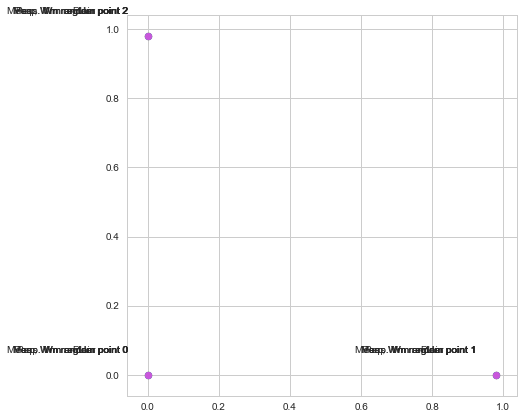

In [7]:
sns.set_palette('hls', len(greedys))
sns.set_style('whitegrid')

fig = plt.figure(figsize=(7,7))

for i, greedy in enumerate(greedys):
    labels = ['{0} point {1}'.format(g_labels[i], j) for j in range(greedy.n)] 
    
    ps = dict_ys[np.array(greedy.dict_sel, dtype=np.int32), :]
    
    plt.scatter(ps[:, 0], ps[:, 1], marker='o')

    for label, x, y in zip(labels, ps[:, 0], ps[:, 1]):
        plt.annotate(
            label, xy=(x, y), xytext=(-20, 20), textcoords='offset points', ha='right', va='bottom')

plt.show()